# Load Dataset


In [ ]:
!unzip /content/Tomato_Dataset.zip -d /content/tomat_dataset/


Archive:  /content/Tomato_Dataset.zip
replace /content/tomat_dataset/Three Classes/Reject/reject (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dataset_path = "/content/tomat_dataset/Three_Classes"


In [ ]:
# Import Stuff
import os
import shutil
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:
import os
import shutil
import random
from pathlib import Path

# Lokasi dataset awal
original_dataset_dir = dataset_path

# Target direktori baru
base_dir = "data_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Buat folder train/val/test dan subfolder untuk tiap kelas
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Rasio split
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Untuk setiap kelas
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    train_images = images[:n_train]
    val_images = images[n_train:n_train+n_val]
    test_images = images[n_train+n_val:]

    for image_name in train_images:
        shutil.copy(os.path.join(class_dir, image_name), os.path.join(train_dir, class_name, image_name))

    for image_name in val_images:
        shutil.copy(os.path.join(class_dir, image_name), os.path.join(val_dir, class_name, image_name))

    for image_name in test_images:
        shutil.copy(os.path.join(class_dir, image_name), os.path.join(test_dir, class_name, image_name))


In [ ]:
# import os
# from rembg import remove
# from PIL import Image
# from pathlib import Path

# def remove_background_from_image(input_path, output_path):
#     """Removes background from a single image and saves it."""
#     try:
#         input_image = Image.open(input_path)
#         output_image = remove(input_image)
#         output_image.save(output_path)
#     except Exception as e:
#         print(f"Error processing {input_path}: {e}")

# # Define new directories for images with backgrounds removed
# processed_dataset_dir = "data_with_background_removed"
# processed_train_dir = os.path.join(processed_dataset_dir, "train")
# processed_val_dir = os.path.join(processed_dataset_dir, "val")
# processed_test_dir = os.path.join(processed_dataset_dir, "test")

# # Create the new directories
# for split_dir in [processed_train_dir, processed_val_dir, processed_test_dir]:
#     os.makedirs(split_dir, exist_ok=True)
#     for class_name in os.listdir(os.path.join(base_dir, "train")): # Use train dir as reference for class names
#         os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)


# # Process images in each split and class
# for split_dir, processed_split_dir in zip([train_dir, val_dir, test_dir], [processed_train_dir, processed_val_dir, processed_test_dir]):
#     for class_name in os.listdir(os.path.join(base_dir, "train")):
#         original_class_dir = os.path.join(split_dir, class_name)
#         processed_class_dir = os.path.join(processed_split_dir, class_name)
#         print(f"Processing images in: {original_class_dir}")
#         for image_name in os.listdir(original_class_dir):
#             input_path = os.path.join(original_class_dir, image_name)
#             output_path = os.path.join(processed_class_dir, image_name)
#             remove_background_from_image(input_path, output_path)

# print("Background removal complete.")

# CNN

# Before

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_size = (128, 128)
batch_size = 32

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True # Added shuffle here for better training with augmentation
)

class_names = train_dataset.class_names

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 1680 files belonging to 3 classes.
Found 240 files belonging to 3 classes.
Found 480 files belonging to 3 classes.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to all datasets
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Apply data augmentation *only* to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
count = 0
for _ in train_dataset:
    count += 1
print(f"Jumlah batch (data point) di train_dataset: {count}")


Jumlah batch (data point) di train_dataset: 53


In [ ]:
total_images = 0
for batch_images, _ in train_dataset:
    total_images += batch_images.shape[0]
print(f"Jumlah total image di train_dataset: {total_images}")


Jumlah total image di train_dataset: 1680


# Before/After

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_model(dataset, dataset_name, class_names):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    # Classification Report
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    disp.ax_.set_title(f'Confusion Matrix - {dataset_name}')
    plt.show()


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Tiga kelas
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.4024 - loss: 1.0496 - val_accuracy: 0.5958 - val_loss: 0.6548
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6423 - loss: 0.6443 - val_accuracy: 0.7458 - val_loss: 0.5717
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6960 - loss: 0.5843 - val_accuracy: 0.7083 - val_loss: 0.5420
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7344 - loss: 0.5605 - val_accuracy: 0.6958 - val_loss: 0.5068
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7530 - loss: 0.5103 - val_accuracy: 0.6667 - val_loss: 0.5969
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7757 - loss: 0.5002 - val_accuracy: 0.7875 - val_loss: 0.4635
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8024 - loss: 0.4902 - val_accuracy: 0.7792 - val_loss: 0.4713
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7808 - loss: 0.4755 - val_accuracy: 0.7667 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━

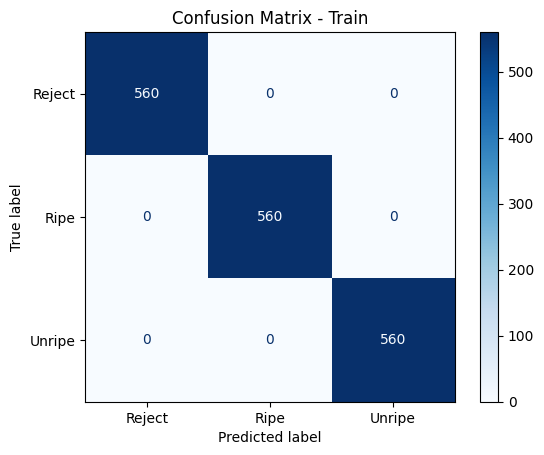

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Classification Report (Validation):
              precision    recall  f1-score   support

      Reject       0.70      0.78      0.73        80
        Ripe       0.79      0.76      0.78        80
      Unripe       0.97      0.90      0.94        80

    accuracy                           0.81       240
   macro avg       0.82      0.81      0.82       240
weighted avg       0.82      0.81      0.82       240



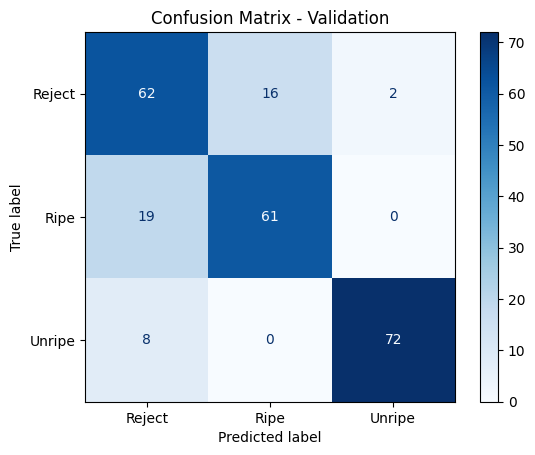

In [ ]:
evaluate_model(train_dataset, "Train", class_names)
evaluate_model(val_dataset, "Validation", class_names)


# After

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7603 - loss: 1.5419

Akurasi Test: 0.80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Classification Report (Test):
              precision    recall  f1-score   support

      Reject       0.67      0.81      0.73       160
        Ripe       0.84      0.77      0.80       160
      Unripe       0.94      0.81      0.87       160

    accuracy                           0.80       480
   macro avg       0.81      0.80

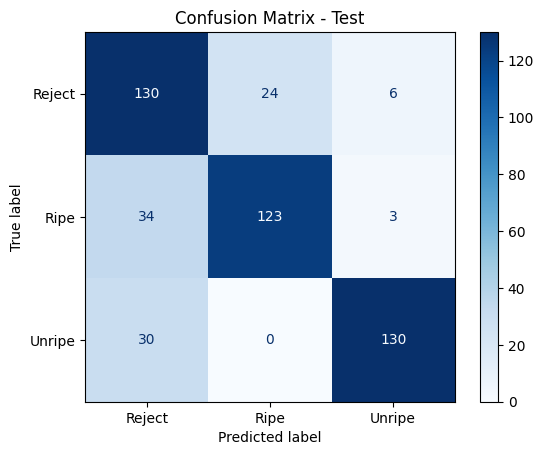

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nAkurasi Test: {test_acc:.2f}")
evaluate_model(test_dataset, "Test", class_names)

In [ ]:
model.save('tomato_cnn_model.h5')

In [ ]:
import os

file_path = 'tomato_cnn_model.h5'  # Ganti dengan nama file kamu
file_size = os.path.getsize(file_path)  # ukuran dalam byte

# Konversi ke satuan MB
file_size_mb = file_size / (1024 * 1024)
print(f"Ukuran file model: {file_size_mb:.2f} MB")

Ukuran file model: 37.87 MB


In [ ]:
import os
from rembg import remove
from PIL import Image
from pathlib import Path

def remove_background_from_image(input_path, output_path):
    """Removes background from a single image and saves it."""
    try:
        input_image = Image.open(input_path)
        output_image = remove(input_image)
        output_image.save(output_path)
    except Exception as e:
        print(f"Error processing {input_path}: {e}")

# Define new directories for images with backgrounds removed
processed_dataset_dir = "data_with_background_removed"
processed_train_dir = os.path.join(processed_dataset_dir, "train")
processed_val_dir = os.path.join(processed_dataset_dir, "val")
processed_test_dir = os.path.join(processed_dataset_dir, "test")

# Create the new directories
for split_dir in [processed_train_dir, processed_val_dir, processed_test_dir]:
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(os.path.join(base_dir, "train")): # Use train dir as reference for class names
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)


# Process images in each split and class
for split_dir, processed_split_dir in zip([train_dir, val_dir, test_dir], [processed_train_dir, processed_val_dir, processed_test_dir]):
    for class_name in os.listdir(os.path.join(base_dir, "train")):
        original_class_dir = os.path.join(split_dir, class_name)
        processed_class_dir = os.path.join(processed_split_dir, class_name)
        print(f"Processing images in: {original_class_dir}")
        for image_name in os.listdir(original_class_dir):
            input_path = os.path.join(original_class_dir, image_name)
            output_path = os.path.join(processed_class_dir, image_name)
            remove_background_from_image(input_path, output_path)

print("Background removal complete.")